In [174]:
# Importing necessary fuctions

import numpy as np
import pandas as pd 
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, validation_curve, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import copy
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LassoCV
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2, RFE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import os
print(os.listdir("../input"))

['turnover.csv']


**I. Data Acquisition**

In [175]:
#Read data file directly from Kaggle
def read_data(input_path):
    raw_data = pd.read_csv(input_path, keep_default_na=False, na_values=['_'])
    return raw_data

raw_data = read_data("../input/turnover.csv")
raw_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [176]:
# Differentiate categorical from numerical variables, even though some are encoded already
cat_raw_data = raw_data[['Work_accident',
                         'left',
                         'promotion_last_5years',
                         'sales',
                         'salary']]

numerical_columns = list(set(raw_data.columns) - set(cat_raw_data.columns))
num_raw_data = raw_data.loc[:,numerical_columns]

In [177]:
# Define functions to be used later in the model   
# Ensure no null values in the data frame 
def ensure_no_nulls(df):
    return df.isnull().T.any().T.sum()

def onehot_encode(df):
    numeric_dtypes = ['int16','int32','int64','float16','float32','float64']
    for categorical_column in cat_raw_data:
        if cat_raw_data[categorical_column].dtype in numeric_dtypes:
            new_df = cat_raw_data
    for categorical_column in cat_raw_data:
        if cat_raw_data[categorical_column].dtype not in numeric_dtypes:
            new_df = pd.concat([new_df,pd.get_dummies(df[categorical_column],
                                                      prefix=categorical_column)],axis=1)
    return new_df

# Determine which variables present skewness
def feature_skewness(df):
    feature_skew = df.apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew

#If the previous function detects skewness, implement Box Cox transformation to make distribution normal
def fix_skewness(df):
    feature_skew = feature_skewness(df)
    high_skew = feature_skew[abs(feature_skew) > 0.5]
    skew_index = high_skew.index
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))
    skew_features = df.apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

# Obtain model accuracy and confusion matrix for each 
def score_model(data, seed=1000):
    X = data.loc[:, data.columns != 'left']
    y = data.loc[:, 'left']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
    regr = linear_model.LogisticRegression(penalty='l1')
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Accuracy: %1.4f" % (accuracy_score(y_test, y_pred)))

# Obtain specific accuracy score 
def print_accuracy(data, seed = 1000):
    X = data.loc[:, data.columns != 'left']
    y = data.loc[:, 'left']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
    regr = linear_model.LogisticRegression(penalty='l1')
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    print("Accuracy: %1.4f" % (accuracy_score(y_test, y_pred)))

**II. Data Understanding**

In [178]:
# Ensure no null values in the data frame 
assert(ensure_no_nulls(raw_data) == 0)

# Check distribution of categorical variables
for i in cat_raw_data.columns:
    dist = cat_raw_data[i].value_counts()/len(cat_raw_data)
    print(dist)

0    0.85539
1    0.14461
Name: Work_accident, dtype: float64
0    0.761917
1    0.238083
Name: left, dtype: float64
0    0.978732
1    0.021268
Name: promotion_last_5years, dtype: float64
sales          0.276018
technical      0.181345
support        0.148610
IT             0.081805
product_mng    0.060137
marketing      0.057204
RandD          0.052470
accounting     0.051137
hr             0.049270
management     0.042003
Name: sales, dtype: float64
low       0.487766
medium    0.429762
high      0.082472
Name: salary, dtype: float64


There are no null values in the data set. 
Values considered 'rare' in the data set (occurrence < 5%):
    - Has been promoted in the past 5 years
    - Is working in either HR or management
 This will be important further along the feature engineering process. 

In [179]:
# Understanding distribution of numerical variables 
num_raw_data.describe()

,last_evaluation,number_project,time_spend_company,satisfaction_level,average_montly_hours
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.716102,3.803054,3.498233,0.612834,201.050337
std,0.171169,1.232592,1.460136,0.248631,49.943099
min,0.360000,2.000000,2.000000,0.090000,96.000000
25%,0.560000,3.000000,3.000000,0.440000,156.000000
50%,0.720000,4.000000,3.000000,0.640000,200.000000
75%,0.870000,5.000000,4.000000,0.820000,245.000000
max,1.000000,7.000000,10.000000,1.000000,310.000000


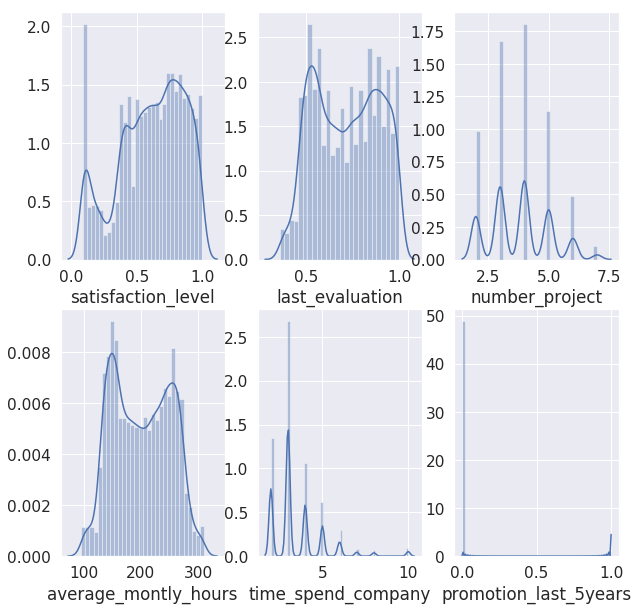

In [180]:
fig,ax = plt.subplots(2,3, figsize=(10,10))               # 'ax' has references to all the four axes
sns.distplot(raw_data['satisfaction_level'], ax = ax[0,0]) 
sns.distplot(raw_data['last_evaluation'], ax = ax[0,1]) 
sns.distplot(raw_data['number_project'], ax = ax[0,2]) 
sns.distplot(raw_data['average_montly_hours'], ax = ax[1,0]) 
sns.distplot(raw_data['time_spend_company'], ax = ax[1,1]) 
sns.distplot(raw_data['promotion_last_5years'], ax = ax[1,2])
 
plt.show()

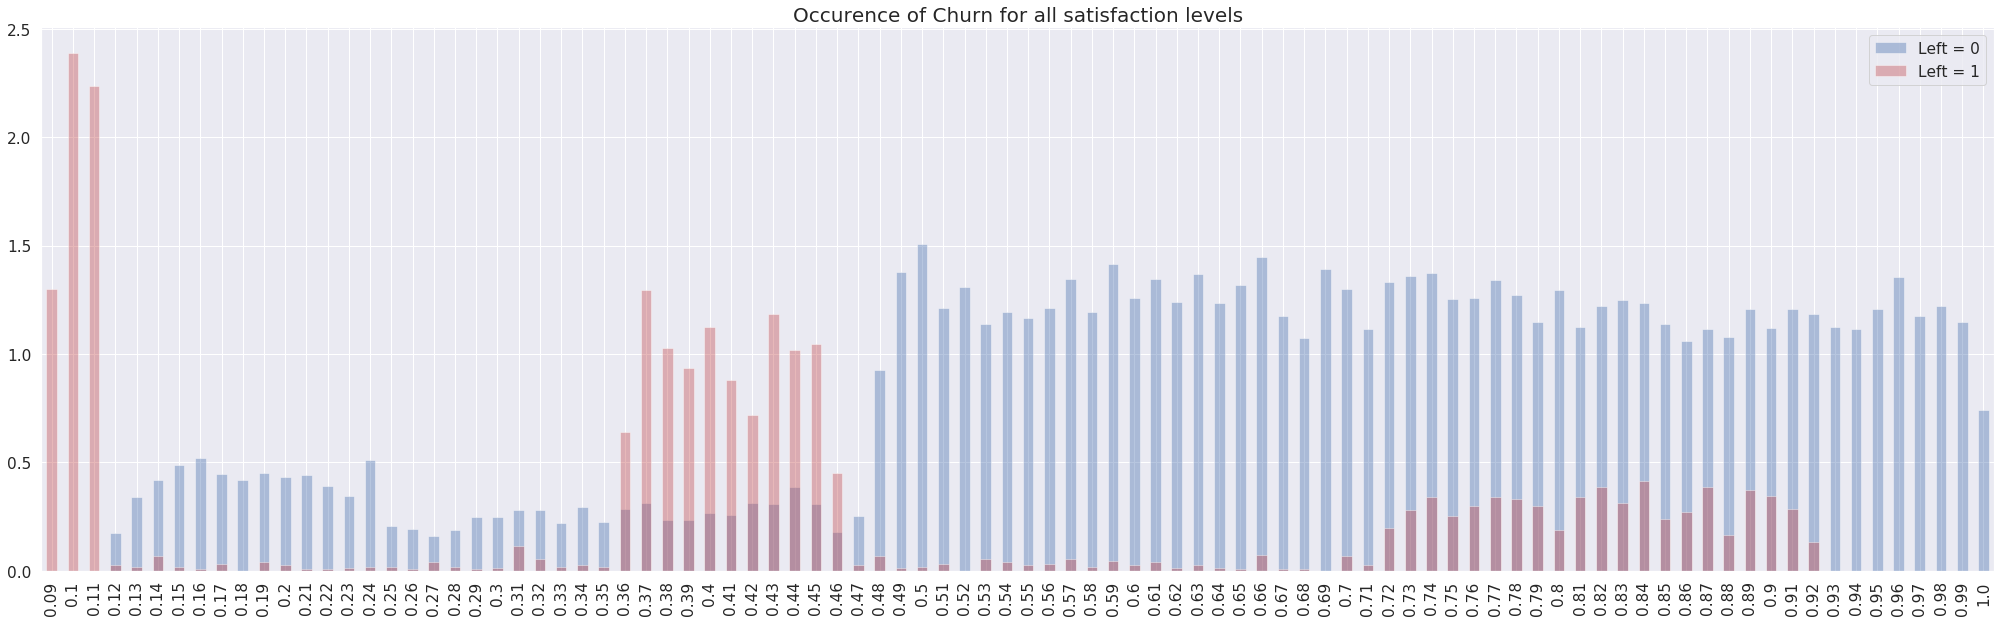

In [181]:
# Target which variables 
raw_data.satisfaction_level = raw_data.satisfaction_level.astype('category')
ax = pd.Series((raw_data[raw_data.left==0].satisfaction_level.value_counts()/len(raw_data.left))*100).sort_index().plot(kind='bar',color='b',figsize=(35,10),alpha=0.4)
pd.Series((raw_data[raw_data.left==1].satisfaction_level.value_counts()/len(raw_data.left))*100).sort_index().plot(kind='bar',color='r',figsize=(35,10),alpha = 0.4, ax=ax)
ax.legend(["Left = 0", "Left = 1"])
plt.title('Occurence of Churn for all satisfaction levels',fontsize=20)
plt.rcParams.update({'font.size': 22})

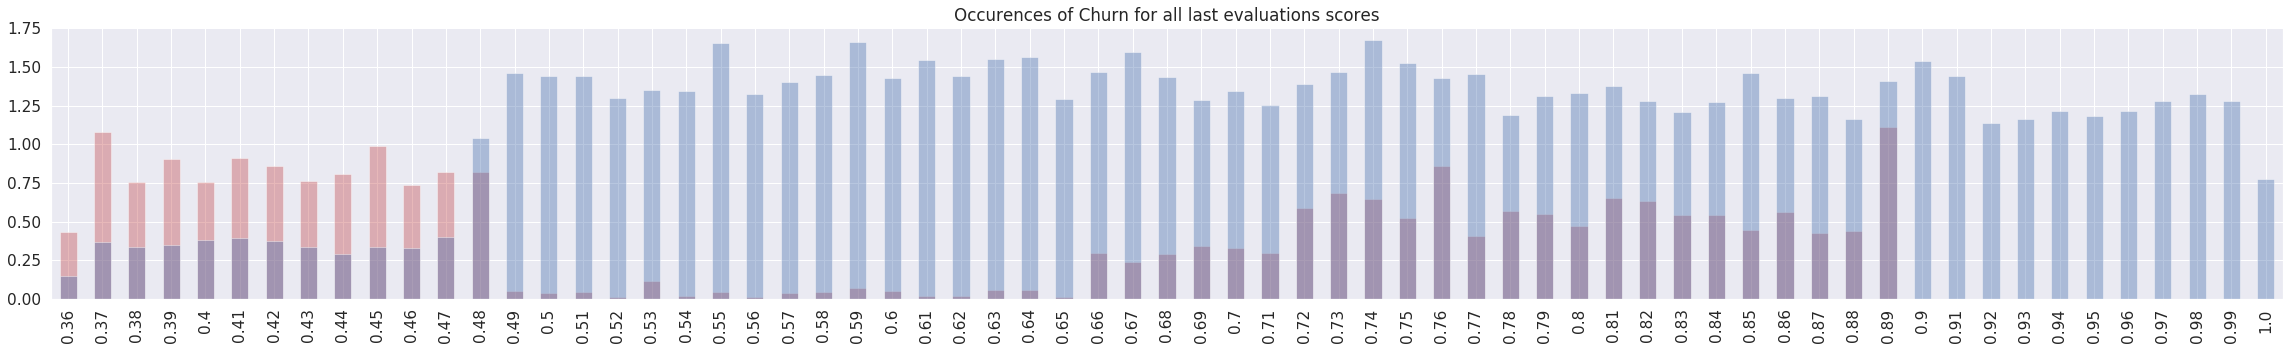

In [182]:
plt.figure(figsize=(40,5))
raw_data.satisfaction_level = raw_data.last_evaluation.astype('category')
((raw_data[raw_data.left==1].last_evaluation.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='r',alpha = 0.4)
((raw_data[raw_data.left==0].last_evaluation.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='b',alpha=0.4)
ax.legend(["Left = 0", "Left = 1"])
plt.title('Occurences of Churn for all last evaluations scores')
plt.rcParams.update({'font.size': 22})

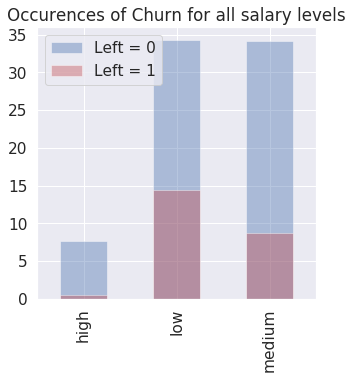

In [183]:
plt.figure(figsize=(5,5))
ax = ((raw_data[raw_data.left==0].salary.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='b',alpha = 0.4)
((raw_data[raw_data.left==1].salary.value_counts().sort_index()/len(raw_data.left)*100)).plot(kind='bar',color='r',alpha = 0.4, ax= ax)
ax.legend(["Left = 0", "Left = 1"])
plt.title('Occurences of Churn for all salary levels')
plt.rcParams.update({'font.size': 10})

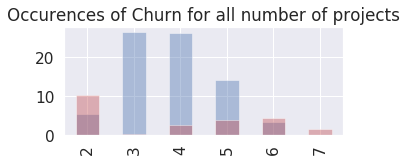

In [184]:
plt.figure(figsize=(5,2))
((raw_data[raw_data.left==0].number_project.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='b',alpha = 0.4)
((raw_data[raw_data.left==1].number_project.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='r',alpha = 0.4)
ax.legend(["Left = 0", "Left = 1"])
plt.title('Occurences of Churn for all number of projects')
plt.rcParams.update({'font.size': 10})

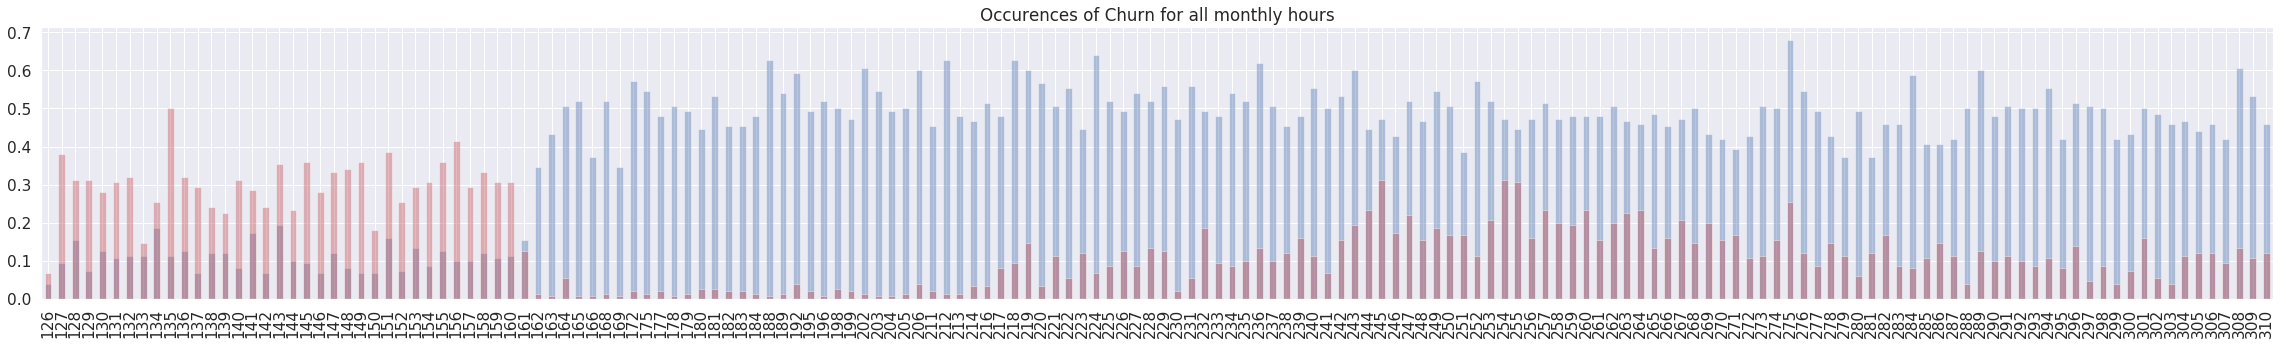

In [185]:
plt.figure(figsize=(40,5))
((raw_data[raw_data.left==0].average_montly_hours.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='b',alpha=0.4)
((raw_data[raw_data.left==1].average_montly_hours.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='r',alpha=0.4)
ax.legend(["Left = 0", "Left = 1"])
plt.title('Occurences of Churn for all monthly hours')
plt.rcParams.update({'font.size': 10})

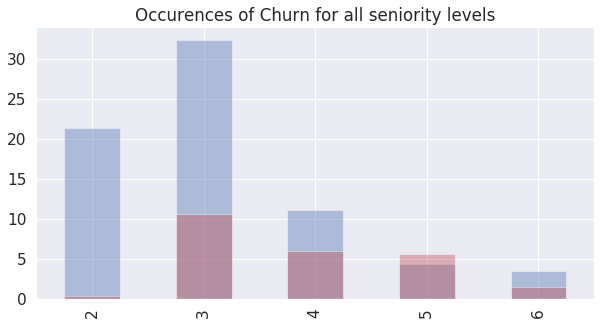

In [186]:
plt.figure(figsize=(10,5))
((raw_data[raw_data.left==0].time_spend_company.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='b',alpha = 0.4)
((raw_data[raw_data.left==1].time_spend_company.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='r',alpha=0.4)
ax.legend(["Left = 0", "Left = 1"])
plt.title('Occurences of Churn for all seniority levels')
plt.rcParams.update({'font.size': 10})

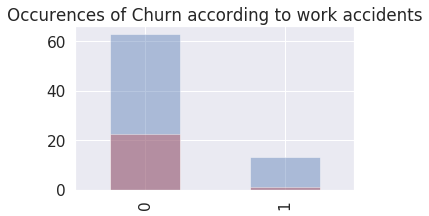

In [187]:
plt.figure(figsize=(5,3))
((raw_data[raw_data.left==0].Work_accident.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='b', alpha = 0.4)
((raw_data[raw_data.left==1].Work_accident.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='r',alpha=0.4)
ax.legend(["Left = 0", "Left = 1"])
plt.title('Occurences of Churn according to work accidents')
plt.rcParams.update({'font.size': 10})

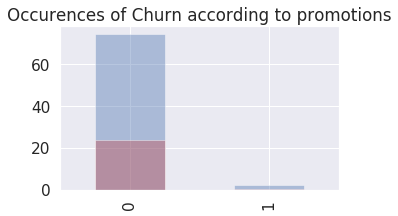

In [188]:
plt.figure(figsize=(5,3))
((raw_data[raw_data.left==0].promotion_last_5years.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='b', alpha = 0.4)
((raw_data[raw_data.left==1].promotion_last_5years.value_counts().sort_index()/len(raw_data.left))*100).plot(kind='bar',color='r',alpha=0.4)
plt.title('Occurences of Churn according to promotions')
plt.rcParams.update({'font.size': 10})

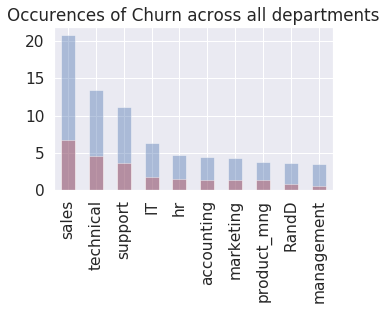

In [189]:
plt.figure(figsize=(5,3))
((raw_data[raw_data.left==0].sales.value_counts()/len(raw_data.left))*100).plot(kind='bar',color='b', alpha = 0.4)
((raw_data[raw_data.left==1].sales.value_counts()/len(raw_data.left))*100).plot(kind='bar',color='r',alpha=0.4)
plt.title('Occurences of Churn across all departments')
plt.rcParams.update({'font.size': 10})

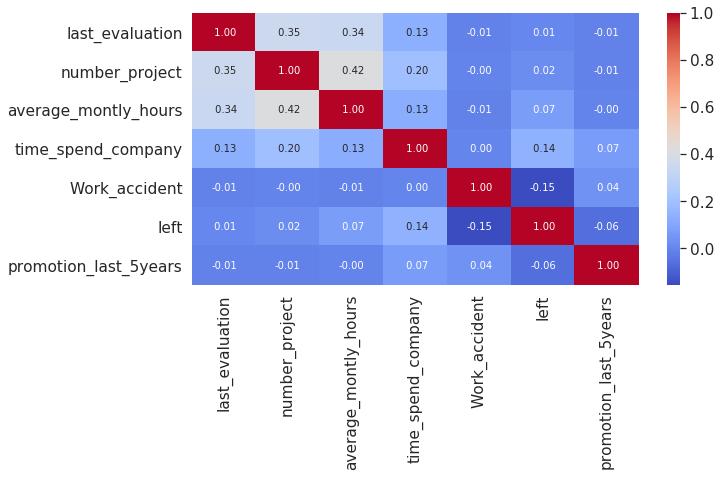

In [190]:
plt.figure(figsize=(10,5))
sns.heatmap(raw_data.corr(),cbar=True,fmt =' .2f', annot=True, cmap='coolwarm')
sns.set(font_scale=1.4)
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)


**III. Data Preparation**

In [191]:
lkup = {"low": 0, "medium": 1, "high": 2}
raw_data['sal_num'] = raw_data['salary'].map(lkup)
raw_data.drop('salary', inplace=True, axis=1)
num_raw_data['sal_num'] = raw_data['sal_num']

In [192]:
cat_raw_data.drop('salary', inplace=True, axis=1)
raw_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,sal_num
0,0.53,0.53,2,157,3,0,1,0,sales,0
1,0.86,0.86,5,262,6,0,1,0,sales,1
2,0.88,0.88,7,272,4,0,1,0,sales,1
3,0.87,0.87,5,223,5,0,1,0,sales,0
4,0.52,0.52,2,159,3,0,1,0,sales,0


In [193]:
## Data Preparation
feature_skewness(num_raw_data)
fix_skewness(num_raw_data).head()

,last_evaluation,number_project,time_spend_company,satisfaction_level,average_montly_hours,sal_num
0,0.53,2,0.886558,0.38,157,0.00000
1,0.86,5,1.061627,0.80,262,0.93578
2,0.88,7,0.964686,0.11,272,0.93578
3,0.87,5,1.020041,0.72,223,0.00000
4,0.52,2,0.886558,0.37,159,0.00000


In [194]:
onehot_encode(raw_data).head()

,Work_accident,left,promotion_last_5years,sales,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0,1,0,sales,0,0,0,0,0,0,0,1,0,0
1,0,1,0,sales,0,0,0,0,0,0,0,1,0,0
2,0,1,0,sales,0,0,0,0,0,0,0,1,0,0
3,0,1,0,sales,0,0,0,0,0,0,0,1,0,0
4,0,1,0,sales,0,0,0,0,0,0,0,1,0,0


In [195]:
#Merge numerical and categorical variables in the same data frame
dataset = fix_skewness(num_raw_data).merge(onehot_encode(raw_data).drop(['sales'],axis=1), how='outer', left_index=True, right_index=True)
dataset.head()

,last_evaluation,number_project,time_spend_company,satisfaction_level,average_montly_hours,sal_num,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.53,2,0.886558,0.38,157,0.00000,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.86,5,1.061627,0.80,262,0.93578,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0.88,7,0.964686,0.11,272,0.93578,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0.87,5,1.020041,0.72,223,0.00000,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.52,2,0.886558,0.37,159,0.00000,0,1,0,0,0,0,0,0,0,0,1,0,0


**IV. Establish Baseline Model**

In [196]:
## Establish Baseline Model with Logistic Regression:
score_model(dataset)

[[3147  284]
 [ 646  423]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      3431
           1       0.60      0.40      0.48      1069

   micro avg       0.79      0.79      0.79      4500
   macro avg       0.71      0.66      0.67      4500
weighted avg       0.77      0.79      0.78      4500

Accuracy: 0.7933


**V. Feature Engineering - Feature Creation**

In [197]:
## Feature Engineering

# Feature Construction
# Standardize numerical columns since they are measured on different scales
def standardize(df):
    df.iloc[:, 0:5] = StandardScaler().fit_transform(df.iloc[:, 0:5])
    return df

# Cluster personnel between functional and support activities
def cluster_functions(df):
    df['support_fuction'] = ""
    filter_col = [col for col in df if col.startswith('sales_')]
    for i in range(len(df[filter_col])):
        if df.at[i,'sales_accounting'] == 1 or df.at[i,'sales_hr'] == 1 or df.at[i,'sales_management'] == 1:
            df['support_fuction'] = 1
        else:
            df['support_fuction'] = 0
    return df

# Other functions needed in feature engineering
# Remove outliers, still for target 'left'
def remove_outliers(df):
    X = df.drop(['left'], axis=1)
    y = df.left.reset_index(drop=True)
    ols = sm.OLS(endog = y, exog = X)
    fit = ols.fit()
    test = fit.outlier_test()['bonf(p)']
    outliers = list(test[test<1e-3].index)
    df.drop(df.index[outliers])
    return df

# Binning a few variables (with pandas library)
def bin_variables_quartiles(df):
    variables=['average_montly_hours','satisfaction_level','last_evaluation']
    for field in variables:
        min=df[field].min()-1
        q1=df[field].quantile(0.25)
        q2=df[field].quantile(0.50)
        q3=df[field].quantile(0.75)
        max=df[field].max()+1
        bins = [min, q1, q2, q3, max]
        group_names = ['1Q', '2Q', '3Q', '4Q']
        df["BINNED_"+field]= pd.cut(df[field], bins, labels=group_names)
    new_df = df[df.columns[-3:]]
    numeric_dtypes = ['int16','int32','int64','float16','float32','float64']
    for i in new_df.columns:
        if new_df[i].dtype not in numeric_dtypes:
            new_df = pd.concat([new_df,pd.get_dummies(new_df[i],prefix=i)],axis=1)
    new_df = df.merge(new_df.drop(['BINNED_average_montly_hours','BINNED_satisfaction_level','BINNED_last_evaluation'],
                                  axis=1), how='outer', left_index=True, right_index=True) 
    new_df = new_df.drop(['BINNED_average_montly_hours','BINNED_satisfaction_level','BINNED_last_evaluation'],axis=1)
    return new_df

#Construct bins appropriate for the dataset

def bin_variables(df):
    bins = [0, 0.11, 0.35, 0.46, 0.71, 0.92,1.0]
    df['satisfaction_level_bin'] = pd.cut(df.satisfaction_level,bins)
    bins = [0, 0.47, 0.48, 0.65, 0.88, 0.89,1.0]
    df['last_evaluation_bin'] = pd.cut(df.last_evaluation,bins)
    lkup = { 3: "low", 4 : "medium", 5 : "medium",  2: "high", 6: "high", 7: "Very high"}
    df['number_project_cat'] = df['number_project'].map(lkup)
    bins = [96, 131, 165, 178, 179, 259, 287]
    df['average_montly_hours_bin'] = pd.cut(df.average_montly_hours,bins)
    bins = [0, 0.8, 0.9, 0.98, 1.04, 1.1]
    df['time_spend_company_bin'] = pd.cut(df.time_spend_company,bins)
    df = pd.concat([df, pd.get_dummies(df['satisfaction_level_bin'],prefix='sts', prefix_sep='_')], axis=1)
    df.drop('satisfaction_level', inplace=True, axis=1)
    df.drop('satisfaction_level_bin', inplace=True, axis=1)
    df = pd.concat([df, pd.get_dummies(df['last_evaluation_bin'],prefix='le', prefix_sep='_')], axis=1)
    df.drop('last_evaluation_bin', inplace=True, axis=1)
    df.drop('last_evaluation', inplace=True, axis=1)
    df = pd.concat([df, pd.get_dummies(df['number_project_cat'],prefix='np', prefix_sep='_')], axis=1)
    df.drop('number_project_cat', inplace=True, axis=1)
    df.drop('number_project', inplace=True, axis=1)
    df = pd.concat([df, pd.get_dummies(df['average_montly_hours_bin'],prefix='am', prefix_sep='_')], axis=1)
    df.drop('average_montly_hours_bin', inplace=True, axis=1)
    df.drop('average_montly_hours', inplace=True, axis=1)
    df = pd.concat([df, pd.get_dummies(df['time_spend_company_bin'],prefix='tsc', prefix_sep='_')], axis=1)
    df.drop('time_spend_company_bin', inplace=True, axis=1)
    df.drop('time_spend_company', inplace=True, axis=1)
    return df

# Find the features with underrepresented attributes
def under_represented_features(df):
    under_rep = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if ((zeros / len(df)) * 100) > 95.0:
            under_rep.append(i)
    df.drop(under_rep, axis=1, inplace=True)
    return df

In [198]:
# Check for improvements over Baseline
score_model(dataset.copy())
score_model(standardize(dataset.copy()))
score_model(cluster_functions(dataset.copy()))
score_model(under_represented_features(dataset.copy()))
score_model(bin_variables(dataset.copy()))
score_model(bin_variables_quartiles(dataset.copy()))

[[3147  284]
 [ 646  423]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      3431
           1       0.60      0.40      0.48      1069

   micro avg       0.79      0.79      0.79      4500
   macro avg       0.71      0.66      0.67      4500
weighted avg       0.77      0.79      0.78      4500

Accuracy: 0.7933
[[3143  288]
 [ 648  421]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      3431
           1       0.59      0.39      0.47      1069

   micro avg       0.79      0.79      0.79      4500
   macro avg       0.71      0.65      0.67      4500
weighted avg       0.77      0.79      0.78      4500

Accuracy: 0.7920
[[3151  280]
 [ 644  425]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      3431
           1       0.60      0.40      0.48      1069

   micro avg       0.79      0.79      0.79      4500
   macro avg 

In [199]:
dataset = bin_variables(dataset)
dataset.shape

(14999, 41)

**VI. Feature Engineering - Feature Selection**

In [200]:
## Feature Selection
X = dataset.drop(labels=["left"],axis=1)
Y = dataset['left']

# Stepwise function
def stepwise_selection(X, Y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(Y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(Y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Information Gain Function
def information_gain(df):
    res = dict(zip(df.drop(labels=["left"],axis=1).columns,
                   mutual_info_classif(X, Y, discrete_features=True)))
    res = sorted(res.items(), key=lambda x: x[1], reverse=True)
    return res

# Chi-squared Stats, for top 5 most significant categorical variables
def get_chi2_test(df):
    chi2_dataset = df.drop(labels=['left'],axis=1)
    x = chi2_dataset
    Y = dataset['left']
    # Feature extraction
    test = SelectKBest(score_func=chi2, k=10)
    fit = test.fit(x, Y)
    # Summarize scores
    np.set_printoptions(precision=3)
    print(fit.scores_)
    features = fit.transform(x)
    # Summarize selected features
    print(features[0:10,:])
    # Obtain the column labels
    x.columns[test.get_support(indices=True)]
    vector_names = list(x.columns[test.get_support(indices=True)])
    print(vector_names)

In [201]:
X = dataset.drop(labels=["left"],axis=1)
Y = dataset['left']
result = stepwise_selection(X, Y)

print('resulting features:')
print(result)

Add  sts_(0.35, 0.46]               with p-value 0.0
Add  tsc_(0.98, 1.04]               with p-value 0.0
Add  np_Very high                   with p-value 0.0
Add  sts_(0.0, 0.11]                with p-value 0.0
Add  sts_(0.71, 0.92]               with p-value 4.70835e-137
Add  np_high                        with p-value 4.00358e-107
Add  le_(0.89, 1.0]                 with p-value 6.81623e-61
Add  np_medium                      with p-value 1.11032e-50
Add  tsc_(1.04, 1.1]                with p-value 1.08631e-45
Add  sal_num                        with p-value 3.56707e-35
Add  Work_accident                  with p-value 4.46518e-31
Add  am_(165, 178]                  with p-value 2.36235e-29
Add  am_(96, 131]                   with p-value 1.22794e-32
Add  tsc_(0.0, 0.8]                 with p-value 3.73372e-24
Add  sts_(0.11, 0.35]               with p-value 8.05895e-23
Add  am_(179, 259]                  with p-value 1.85915e-11
Add  promotion_last_5years          with p-value 3.855

In [202]:
information_gain(dataset)

[('np_high', 0.11494812401168297),
 ('sts_(0.35, 0.46]', 0.10205141531126687),
 ('sts_(0.0, 0.11]', 0.09123837587054506),
 ('sts_(0.46, 0.71]', 0.07524711567771479),
 ('np_low', 0.06751235137388635),
 ('tsc_(0.0, 0.8]', 0.052552245451108946),
 ('tsc_(0.98, 1.04]', 0.027358761452307853),
 ('sts_(0.92, 1.0]', 0.026078007591957414),
 ('np_Very high', 0.024975112248797005),
 ('np_medium', 0.023089601455358988),
 ('am_(179, 259]', 0.020550355000067744),
 ('am_(165, 178]', 0.016499668181326338),
 ('Work_accident', 0.01454223778880688),
 ('sal_num', 0.014483912915501673),
 ('le_(0.65, 0.88]', 0.011083442705596636),
 ('am_(131, 165]', 0.01086524721693774),
 ('sts_(0.11, 0.35]', 0.008728334222479366),
 ('tsc_(0.9, 0.98]', 0.006403508473172365),
 ('le_(0.89, 1.0]', 0.004372019036923136),
 ('am_(259, 287]', 0.002846816213531833),
 ('le_(0.0, 0.47]', 0.002526291024488564),
 ('promotion_last_5years', 0.0024956688052774068),
 ('le_(0.47, 0.48]', 0.0024479132252004585),
 ('sts_(0.71, 0.92]', 0.002447

In [203]:
# Perform Chi-Squared test for most significant categorical variables
get_chi2_test(dataset)    

[2.281e+02 3.067e+02 5.604e+01 1.644e+00 3.086e+01 3.289e+00 1.138e+01
 3.045e+01 1.044e-02 1.715e+00 1.069e+00 1.462e+00 4.949e+00 2.842e+03
 1.921e+02 3.137e+03 1.188e+03 4.884e+01 4.256e+02 7.757e+01 8.344e+01
 1.020e-01 1.992e+02 3.931e+00 1.104e+02 8.193e+02 2.922e+03 1.085e+03
 3.531e+02 1.700e+01 2.537e+02 3.014e+02 1.786e+01 3.245e+02 7.895e+01
 8.793e+02 2.317e+00 1.705e+02 8.706e+02 2.734e-01]
[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]]
['sts_(0.0, 0.11]', 'sts_(0.35, 0.46]', 'sts_(0.46, 0.71]', 'sts_(0.92, 1.0]', 'np_Very high', 'np_high', 'np_low', 'np_medium', 'tsc_(0.0, 0.8]', 'tsc_(0.98, 1.04]']


In [204]:
# Recursive Feature Elimination
model = LogisticRegression(class_weight='balanced')
rfe = RFE(model)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

def get_column_names(lst):
    l = []
    for i in range(len(lst)):
        if lst[i] == True:
            l.append(X.columns[i])
    return l

get_column_names(fit.support_)

Num Features: 20
Selected Features: [False  True  True False False False False False False False False False
 False  True  True  True  True False  True False False False False False
 False  True False  True  True  True  True  True  True  True  True False
  True  True  True  True]
Feature Ranking: [ 3  1  1  7  6 14 11  5 18  4 17 15 13  1  1  1  1 19  1  9 12 20 21 10
  2  1  8  1  1  1  1  1  1  1  1 16  1  1  1  1]


['Work_accident',
 'promotion_last_5years',
 'sts_(0.0, 0.11]',
 'sts_(0.11, 0.35]',
 'sts_(0.35, 0.46]',
 'sts_(0.46, 0.71]',
 'sts_(0.92, 1.0]',
 'np_Very high',
 'np_low',
 'np_medium',
 'am_(96, 131]',
 'am_(131, 165]',
 'am_(165, 178]',
 'am_(178, 179]',
 'am_(179, 259]',
 'am_(259, 287]',
 'tsc_(0.8, 0.9]',
 'tsc_(0.9, 0.98]',
 'tsc_(0.98, 1.04]',
 'tsc_(1.04, 1.1]']

In [205]:
for i in range(1,41):
    lst = list(get_column_names(fit.support_))[:i]
    lst.extend(['left'])
    dataset_1 = dataset.loc[:,lst]
    print('With %s variables:'%i)
    print_accuracy(dataset_1)

With 1 variables:
Accuracy: 0.7624
With 2 variables:
Accuracy: 0.7624
With 3 variables:
Accuracy: 0.8187
With 4 variables:
Accuracy: 0.8187
With 5 variables:
Accuracy: 0.8896
With 6 variables:
Accuracy: 0.8896
With 7 variables:
Accuracy: 0.8896
With 8 variables:
Accuracy: 0.8911
With 9 variables:
Accuracy: 0.8996
With 10 variables:
Accuracy: 0.9020
With 11 variables:
Accuracy: 0.9018
With 12 variables:
Accuracy: 0.9018
With 13 variables:
Accuracy: 0.8944
With 14 variables:
Accuracy: 0.8947
With 15 variables:
Accuracy: 0.9029
With 16 variables:
Accuracy: 0.9031
With 17 variables:
Accuracy: 0.8962
With 18 variables:
Accuracy: 0.8980
With 19 variables:
Accuracy: 0.9449
With 20 variables:
Accuracy: 0.9460
With 21 variables:
Accuracy: 0.9460
With 22 variables:
Accuracy: 0.9460
With 23 variables:
Accuracy: 0.9460
With 24 variables:
Accuracy: 0.9460
With 25 variables:
Accuracy: 0.9460
With 26 variables:
Accuracy: 0.9460
With 27 variables:
Accuracy: 0.9460
With 28 variables:
Accuracy: 0.9460
W

**VII. Model Evaluation**

In [206]:
# Lasso Regression

import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
# difference of lasso and ridge regression is that some of the coefficients can be zero i.e. some of the features are 
# completely neglected
from sklearn.linear_model import Lasso
#print cancer_df.head(3)
X = dataset.drop(labels=["left"],axis=1)
Y = dataset['left']
X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=31)
lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print("training score for alpha=0.01:", train_score001)
print("test score for alpha =0.01: ", test_score001)
print("number of features used: for alpha =0.01:", coeff_used001)
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)
train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print("training score for alpha=0.0001:", train_score00001)
print("test score for alpha =0.0001: ", test_score00001)
print ("number of features used: for alpha =0.0001:", coeff_used00001)
lasso0000001 = Lasso(alpha=0.000001, max_iter=10e5)
lasso0000001.fit(X_train,y_train)
train_score0000001=lasso0000001.score(X_train,y_train)
test_score0000001=lasso0000001.score(X_test,y_test)
coeff_used0000001 = np.sum(lasso0000001.coef_!=0)
print("training score for alpha=0.000001:", train_score0000001)
print("test score for alpha =0.000001: ", test_score0000001)
print ("number of features used: for alpha =0.000001:", coeff_used0000001)
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)
print("LR training score:", lr_train_score)
print("LR test score: ", lr_test_score)

training score: 0.0
test score:  -1.753892972322646e-05
number of features used:  0
training score for alpha=0.01: 0.594534450981947
test score for alpha =0.01:  0.5908529123494006
number of features used: for alpha =0.01: 13
training score for alpha=0.0001: 0.6527090181527742
test score for alpha =0.0001:  0.6503829516979018
number of features used: for alpha =0.0001: 38
training score for alpha=0.000001: 0.6528351337083305
test score for alpha =0.000001:  0.6506744774868926
number of features used: for alpha =0.000001: 39
LR training score: 0.9487570244785217
LR test score:  0.9495555555555556


In [207]:
# Cross-Validation with Dataset 
X = dataset.drop(labels=["left"],axis=1)
y = dataset['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=101)
pipeline = make_pipeline(LogisticRegression(n_jobs=-1)).fit(X_train, y_train)
scores = cross_val_score(pipeline, X_train, y_train, scoring="accuracy", cv=cv)

print('Obtained {} positive accuracy scores'.format(len(scores[scores > 0.0])))
print('Best CV accuracy: {:.4f}'.format((max(scores)),digits=4))
print('Avg. CV accuracy: {:.4f} +/- {:.04}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])))
print('Accuracy in hold-out dataset: {:.4f}'.format(pipeline.score(X_test,y_test),4))

Obtained 10 positive accuracy scores
Best CV accuracy: 0.9576
Avg. CV accuracy: 0.9506 +/- 0.004709
Accuracy in hold-out dataset: 0.9504


In [208]:
pipeline = make_pipeline(LogisticRegression(n_jobs=-1)).fit(X_train, y_train)
pipeline.fit(X_train, y_train)
training_score = pipeline.score(X_test, y_test)

print('Accuracy from entire-dataset estimator: {:.4f}'.format(training_score))

# Obtain scores and estimators from different splits and use the best one.
scores = cross_validate(pipeline,X_train, y_train,scoring=['accuracy'],cv=5,return_estimator=True)
split_scores = [scores['estimator'][i].score(X_test, y_test) for i in range(len(scores))]
index_best = split_scores.index(max(split_scores))
print('Best estimator accuracy score: {:.4f}'.format(split_scores[index_best],4))

Accuracy from entire-dataset estimator: 0.9504
Best estimator accuracy score: 0.9522


In [209]:
# Confusion Matrix for Polynomial of Degree 2
def score_model_pol(data, seed=1000):
    pol = PolynomialFeatures(2)
    X = data.loc[:, data.columns != 'left']
    y = data.left.values
    X_train, X_test, y_train, y_test = train_test_split(pol.fit_transform(X.as_matrix()), y, test_size=0.30, random_state=101)
    # Create regression object
    regr = linear_model.LogisticRegression(penalty='l1')
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Accuracy: %1.4f" % (accuracy_score(y_test, y_pred)))
    
score_model_pol(dataset)

[[3389   42]
 [  69 1000]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3431
           1       0.96      0.94      0.95      1069

   micro avg       0.98      0.98      0.98      4500
   macro avg       0.97      0.96      0.97      4500
weighted avg       0.98      0.98      0.98      4500

Accuracy: 0.9753


Text(0.5,1,'New scoring function with k-fold cv with polynomial of degree 2.')

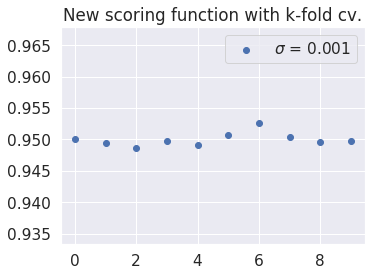

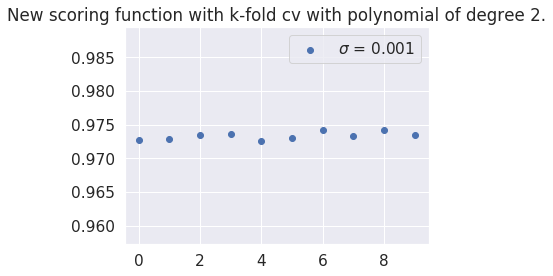

In [210]:
def score_model2(data, seed=666, splits=20):
    X = data.loc[:, data.columns != 'left']
    y = data.loc[:, 'left']
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=seed)
    regr = linear_model.LogisticRegression()
    scores = cross_val_score(regr,X_train, y_train,scoring='accuracy', cv=splits)
    return scores

def score_model3(data, seed=666, splits = 20):
    X = dataset.drop(labels=["left"],axis=1)
    y = dataset['left']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
    cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=101)
    pipeline = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),LogisticRegression(n_jobs=-1)).fit(X_train, y_train)
    scores = cross_val_score(pipeline, X_train, y_train, scoring="accuracy", cv=splits)
    return scores

num_times = 10
scores2 = [np.mean(score_model2(dataset, seed=i)) for i in range(num_times)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(range(len(scores2)), scores2,
label='$\sigma$ = {:.3f}'.format(np.std(scores2)))
plt.legend(loc='best')
plt.title('New scoring function with k-fold cv.')

num_times = 10
scores3 = [np.mean(score_model3(dataset, seed=i)) for i in range(num_times)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plt.scatter(range(len(scores3)), scores3,
label='$\sigma$ = {:.3f}'.format(np.std(scores3)))
plt.legend(loc='best')
plt.title('New scoring function with k-fold cv with polynomial of degree 2.')

In [211]:
## Cross-Validation
X = dataset.drop(labels=["left"],axis=1)
y = dataset['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=101)
pipeline = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),LogisticRegression(n_jobs=-1)).fit(X_train, y_train)
scores = cross_val_score(pipeline, X_train, y_train, scoring="accuracy", cv=cv)

print('Obtained {} positive accuracy scores'.format(len(scores[scores > 0.0])))
print('Best CV accuracy: {:.4f}'.format((max(scores)),digits=4))
print('Avg. CV accuracy: {:.4f} +/- {:.04}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])))
print('Accuracy in hold-out dataset: {:.4f}'.format(pipeline.score(X_test,y_test),4))

Obtained 10 positive accuracy scores
Best CV accuracy: 0.9771
Avg. CV accuracy: 0.9724 +/- 0.002694
Accuracy in hold-out dataset: 0.9749


In [212]:
pipeline = Pipeline([('polynomials', PolynomialFeatures(degree=2, include_bias=False)),
                     ('logistic_regression', LogisticRegression(n_jobs=-1))])
pipeline.fit(X_train, y_train)
training_score = pipeline.score(X_test, y_test)

print('Accuracy from entire-dataset estimator: {:.4f}'.format(training_score))

# Obtain scores and estimators from different splits and use the best one.
scores = cross_validate(pipeline,X_train, y_train,scoring=['accuracy'],cv=5,return_estimator=True)
split_scores = [scores['estimator'][i].score(X_test, y_test) for i in range(len(scores))]
index_best = split_scores.index(max(split_scores))
print('Best estimator accuracy score: {:.4f}'.format(split_scores[index_best],4))

Accuracy from entire-dataset estimator: 0.9749
Best estimator accuracy score: 0.9756
